# MRes Dissertation Code 
1. Research Question : How media classifies different celebrity CEO
2. Data Collection : 100 Most Powerful People in Business - Fortune
3. Data Analysis : Topic Modelling


## Import required libraries
These libraries include basic ones such as <pandas>, ,<numpy> and advanced ones such as <gensim>, <spacy>, <nltk>

In [1]:
import os
import zipfile
from pathlib import Path
import shutil
import spacy
import re
from typing import List, Dict, Tuple, Set
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import pandas as pd
import string
import spacy
import string
from gensim.models import LdaModel, TfidfModel, LsiModel
from collections import Counter
from sklearn.decomposition import NMF

## Initial Data Collection 

### Step 1 : Data Download from Nexis Uni

The {Major Relevance Person Tag} excel sheet was compiled based on the article count derived from Nexis Uni Database
The query used for obtaining the number <PERSON("name"#85PLUS)> in the Nexis Uni database

In [16]:
# Read the Excel file
df = pd.read_excel('/Users/shantanusharma/Desktop/Major Relevance Person Tag.xlsx')

# Extract count data from the third column (Count of Major Relevance)
# Skip the first row which contains headers
count_data = df.iloc[1:, 2].dropna()
count_data = count_data[pd.to_numeric(count_data, errors='coerce').notna()]
count_data = pd.to_numeric(count_data)

total_entries = len(count_data)
min_count = count_data.min()
max_count = count_data.max()
mean_count = count_data.mean()
median_count = count_data.median()
std_count = count_data.std()

print("=== BASIC STATISTICS ===")
print("Total entries:", total_entries)
print("Minimum:", min_count)
print("Maximum:", max_count)
print("Mean:", round(mean_count, 2))
print("Median:", median_count)
print("Standard deviation:", round(std_count, 2))
# Skewness analysis
skewness = count_data.skew()
print("\n=== SKEWNESS ANALYSIS ===")
print("Skewness:", round(skewness, 2))

if skewness > 1:
    print("Distribution: Highly right-skewed")
elif skewness > 0.5:
    print("Distribution: Moderately right-skewed")
elif skewness > -0.5:
    print("Distribution: Approximately symmetric")
elif skewness > -1:
    print("Distribution: Moderately left-skewed")
else:
    print("Distribution: Highly left-skewed")

# Calculate percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\n=== PERCENTILES ===")

for p in percentiles:
    value = np.percentile(count_data, p)
    print(f"{p}th percentile: {value}")

# Focus on 75th percentile
percentile_75 = np.percentile(count_data, 75)
print(f"\n=== 75TH PERCENTILE ANALYSIS ===")
print(f"75th percentile value: {percentile_75}")

# Count how many entries are above/below this threshold
above_75th = sum(count_data > percentile_75)
below_75th = sum(count_data <= percentile_75)
percentage_above = (above_75th / total_entries) * 100

print(f"Entries above 75th percentile: {above_75th} ({round(percentage_above, 1)}%)")
print(f"Entries at or below 75th percentile: {below_75th} ({round(100-percentage_above, 1)}%)")

# Show the actual values above 75th percentile
values_above_75th = count_data[count_data > percentile_75].sort_values(ascending=False)
print(f"\nValues above 75th percentile:")
print(values_above_75th.tolist())

# Summary statistics for data above and below threshold
print(f"\n=== IMPACT OF 75TH PERCENTILE THRESHOLD ===")
data_below = count_data[count_data <= percentile_75]
data_above = count_data[count_data > percentile_75]

print(f"Mean of data below threshold: {round(data_below.mean(), 2)}")
print(f"Mean of data above threshold: {round(data_above.mean(), 2)}")
print(f"Total sum below threshold: {data_below.sum()}")
print(f"Total sum above threshold: {data_above.sum()}")

# Coefficient of variation (measure of relative variability)
cv_original = (std_count / mean_count) * 100
cv_below_threshold = (data_below.std() / data_below.mean()) * 100

print(f"\nCoefficient of variation (original): {round(cv_original, 1)}%")
print(f"Coefficient of variation (below threshold): {round(cv_below_threshold, 1)}%")

=== BASIC STATISTICS ===
Total entries: 82
Minimum: 0
Maximum: 14883
Mean: 600.46
Median: 81.5
Standard deviation: 2256.31

=== SKEWNESS ANALYSIS ===
Skewness: 5.83
Distribution: Highly right-skewed

=== PERCENTILES ===
25th percentile: 19.5
50th percentile: 81.5
75th percentile: 203.5
90th percentile: 661.7000000000008
95th percentile: 2134.0500000000015
99th percentile: 14109.449999999997

=== 75TH PERCENTILE ANALYSIS ===
75th percentile value: 203.5
Entries above 75th percentile: 21 (25.6%)
Entries at or below 75th percentile: 61 (74.4%)

Values above 75th percentile:
[14883, 13928, 2678, 2280, 2160, 1641, 1495, 1427, 677, 524, 476, 446, 383, 379, 359, 343, 249, 226, 224, 206, 205]

=== IMPACT OF 75TH PERCENTILE THRESHOLD ===
Mean of data below threshold: 66.38
Mean of data above threshold: 2151.86
Total sum below threshold: 4049
Total sum above threshold: 45189

Coefficient of variation (original): 375.8%
Coefficient of variation (below threshold): 93.0%


In [17]:
print(df.head())

  Major Relevance Person Tag search                       Unnamed: 1  \
0                Name in PERSON Tag                 Person_Tag_Query   
1                        Musk, Elon       term("elon musk" #85plus#)   
2                   Huang, Jen-Hsun  term("jen-hsun huang" #85plus#)   
3                    Nadella, Satya   term("satya nadella" #85plus#)   
4                   Buffett, Warren  term("warren buffett" #85plus#)   

                 Unnamed: 2  
0  Count of Major Relevance  
1                     14883  
2                        63  
3                       343  
4                      1641  


### Step 2 : Random selection of the high coverage articles
From the analysis above the collection of documents from the Nexis Uni was skewed. To mitigate this issue, only the 70th Percentile articles - 203 articles was used
The article is run interatively with same random seed to ensure reproduceability  

In [11]:
import random

# Set random seed for reproducibility
random.seed(21)
threshold = 203
total_article_count = 14883
# Variables to modify

total_articles = 608 # Update this number for the articles you want to select


calculated_articles = round((total_articles/total_article_count)*threshold,0)
num_random_numbers = int(calculated_articles)

# Generate random numbers within the range of articles
# Article numbers from 1 to total_articles
random_article_numbers = random.sample(range(1, total_articles + 1), num_random_numbers)

# Sort the numbers for easier reading
random_article_numbers.sort()

print("Random Article Selection")
print("=" * 25)
print("Total articles:", total_articles)
print("Numbers requested:", num_random_numbers)
print("Random seed:", 21)
print()
print("Selected article numbers:", random_article_numbers)

Random Article Selection
Total articles: 608
Numbers requested: 8
Random seed: 21

Selected article numbers: [169, 188, 222, 289, 429, 487, 491, 525]


## Parsing Collected Data

### Step 3: Creation of the raw dataframe 
The data was collected for each person in the sample iteratively and stored in the zip file. Before the operation, the data needs to be transformed into a dataframe. 

In [ ]:
def collect_zip_files(source_folder, destination_folder):
    source_path = Path(source_folder)
    destination_path = Path(destination_folder)
    destination_path.mkdir(exist_ok=True)
    
    total_files_collected = 0
    
    for subfolder in source_path.iterdir():
        if subfolder.is_dir():
            zip_files = list(subfolder.glob('*.zip')) + list(subfolder.glob('*.ZIP'))
            
            for zip_file in zip_files:
                original_name = zip_file.name
                destination_file = destination_path / original_name
                
                counter = 1
                base_name = zip_file.stem
                extension = zip_file.suffix
                
                while destination_file.exists():
                    new_name = f"{base_name}_{counter}{extension}"
                    destination_file = destination_path / new_name
                    counter += 1
                
                shutil.copy2(zip_file, destination_file)
                total_files_collected += 1
    
    print(f"Total zip files collected: {total_files_collected}")

source_folder = "/Users/shantanusharma/Desktop/untitled folder 2"
destination_folder = "/Users/shantanusharma/Desktop/Data Coolection Docs"
collect_zip_files(source_folder, destination_folder)

In [ ]:
def read_docx_file(file_path: str) -> str:
    """Read a .docx file and convert it to plain text."""
    try:
        doc = Document(file_path)
        full_text = []
        for paragraph in doc.paragraphs:
            if paragraph.text.strip():
                full_text.append(paragraph.text)
        return '\n'.join(full_text)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""
    
def extract_document_components(document_text: str) -> Dict[str, any]:
    """Extract source name, body text, and year from document."""
    # Extract source name
    lines = document_text.split('\n')
    source_name = None
    
    for i, line in enumerate(lines):
        line = line.strip()
        if line and i + 1 < len(lines):
            next_line = lines[i + 1].strip()
            if re.search(r'(January|February|March|April|May|June|July|August|September|October|November|December).*\d{4}', next_line):
                if not line.startswith('#') and not line.startswith('!') and not line.isupper():
                    source_name = line
                    break
    
    # Extract body text
    body_start_pattern = r'(?:Body|\*\*Body\*\*|__Body__|Section:\s*Body)'
    body_end_pattern = r'(?:Load-Date:|Load Date:|__Load-Date__|Load-Date)'
    
    body_match = re.search(f'{body_start_pattern}(.*?){body_end_pattern}', 
                          document_text, re.DOTALL | re.IGNORECASE)
    
    if body_match:
        body_text = body_match.group(1).strip()
    else:
        fallback_match = re.search(r'Byline:.*?\n(.*?)(?:Load-Date|Load Date)', 
                                  document_text, re.DOTALL | re.IGNORECASE)
        body_text = fallback_match.group(1).strip() if fallback_match else ""
    
    # Clean body text
    body_text = re.sub(r'\*\*|\[\]{\.underline}|\{\.underline\}', '', body_text)
    body_text = re.sub(r'\s+', ' ', body_text).strip()
    
    # Extract year
    year_patterns = [
        r'Load-Date:.*?(\d{4})',
        r'Load Date:.*?(\d{4})',
        r'__Load-Date__.*?(\d{4})',
        r'(\d{4})\s*End of Document'
    ]
    
    year = None
    for pattern in year_patterns:
        year_match = re.search(pattern, document_text, re.IGNORECASE)
        if year_match:
            year = int(year_match.group(1))
            break
    
    return {
        'source_name': source_name,
        'body_text': body_text,
        'year': year
    }

def extract_person_sentences_with_context(text: str, last_name: str, nlp) -> str:
    """Extract sentences containing the person's name with context."""
    if not text or pd.isna(text):
        return ""
    
    doc = nlp(text)
    
    # Create name variations
    name_variations = [last_name]
    name_variations.extend([f"Mr. {last_name}", f"Ms. {last_name}", 
                           f"Mrs. {last_name}", f"Dr. {last_name}"])
    
    relevant_text_parts = []
    sentences = list(doc.sents)
    
    for i, sent in enumerate(sentences):
        sent_text = sent.text.strip()
        if any(name.lower() in sent_text.lower() for name in name_variations):
            # Add previous sentence if exists
            if i > 0:
                relevant_text_parts.append(sentences[i-1].text.strip())
            # Add current sentence
            relevant_text_parts.append(sent_text)
            # Add next sentence if exists
            if i < len(sentences) - 1:
                relevant_text_parts.append(sentences[i+1].text.strip())
    
    # Remove duplicates while preserving order
    seen = set()
    relevant_text_cleaned = []
    for text in relevant_text_parts:
        if text not in seen:
            seen.add(text)
            relevant_text_cleaned.append(text)
    
    return ' '.join(relevant_text_cleaned) if relevant_text_cleaned else ""

# ===== TEXT PREPROCESSING =====

def preprocess_text(text: str) -> str:
    """Preprocess text according to specified steps."""
    if pd.isna(text) or not text:
        return ""
    
    # 1. Convert special characters to ASCII equivalents
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    
    # 2. Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # 3. Remove words starting with @ or #
    text = re.sub(r'[@#]\w+', '', text)
    
    # 4. Remove non-English characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # 5. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 6. Remove extra whitespace
    text = ' '.join(text.split())
    
    # 7. Convert to lowercase
    text = text.lower()
    
    # 8. Remove extra punctuation
    text = re.sub(r'([!?.]){2,}', r'\1', text)
    
    return text.strip()

def collect_all_ceo_documents(main_folder_path: str) -> pd.DataFrame:
    """
    Collect all documents from CEO subfolders and create initial dataframe.
    
    Args:
        main_folder_path: Path to main folder containing CEO subfolders
    
    Returns:
        DataFrame with columns: CEO_Name, Source, Year, Body_Text, File_Path
    """
    all_documents = []
    
    # Get all subfolders (CEO folders)
    ceo_folders = [f for f in os.listdir(main_folder_path) 
                   if os.path.isdir(os.path.join(main_folder_path, f))]
    
    print(f"Found {len(ceo_folders)} CEO folders")
    
    # Process each CEO folder
    for ceo_folder in tqdm(ceo_folders, desc="Processing CEO folders"):
        # Extract CEO name from folder name
        ceo_name = ceo_folder.replace('_', ' ')
        
        ceo_folder_path = os.path.join(main_folder_path, ceo_folder)
        
        # Get all .docx files in the folder
        docx_files = [f for f in os.listdir(ceo_folder_path) 
                     if f.lower().endswith('.docx') and not f.startswith('~')]
        
        print(f"\n{ceo_name}: Found {len(docx_files)} documents")
        
        # Process each document
        for docx_file in docx_files:
            file_path = os.path.join(ceo_folder_path, docx_file)
            
            # Read document
            doc_text = read_docx_file(file_path)
            
            if not doc_text:
                continue
            
            # Extract components
            components = extract_document_components(doc_text)
            
            # Add to list
            all_documents.append({
                'CEO_Name': ceo_name,
                'Source': components['source_name'],
                'Year': components['year'],
                'Body_Text': components['body_text'],
                'File_Path': file_path,
                'Filename': docx_file
            })
    
    # Create DataFrame
    df_raw = pd.DataFrame(all_documents)
    
    print(f"\nTotal documents collected: {len(df_raw)}")
    print(f"CEOs with data: {df_raw['CEO_Name'].nunique()}")
    print(f"Sources found: {df_raw['Source'].nunique()}")
    print(f"Year range: {df_raw['Year'].min()} - {df_raw['Year'].max()}")
    
    return df_raw

def create_ner_extracted_dataframe(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Apply NER extraction with context to create extracted text dataframe.
    
    Args:
        df_raw: Raw dataframe with body text
    
    Returns:
        DataFrame with NER-extracted text
    """
    print("\nApplying NER extraction with context...")
    
    extracted_data = []
    
    # Group by CEO for efficient processing
    for ceo_name, group in tqdm(df_raw.groupby('CEO_Name'), desc="Processing CEOs"):
        # Get last name for NER
        last_name = ceo_name.split()[-1]
        
        for idx, row in group.iterrows():
            # Extract relevant sentences with context
            extracted_text = extract_person_sentences_with_context(
                row['Body_Text'], last_name, nlp
            )
            
            if extracted_text:  # Only add if text was found
                extracted_data.append({
                    'CEO_Name': ceo_name,
                    'Source': row['Source'],
                    'Year': row['Year'],
                    'Extracted_Text': extracted_text,
                    'Filename': row['Filename']
                })
    
    df_extracted = pd.DataFrame(extracted_data)
    
    print(f"\nNER extraction complete!")
    print(f"Documents with extracted text: {len(df_extracted)}")
    print(f"Documents without matches: {len(df_raw) - len(df_extracted)}")
    
    return df_extracted

def create_preprocessed_dataframe(df_extracted: pd.DataFrame, min_words: int = 50) -> pd.DataFrame:
    """
    Create preprocessed version of extracted text dataframe.
    
    Args:
        df_extracted: DataFrame with NER-extracted text
        min_words: Minimum word count threshold
    
    Returns:
        DataFrame with preprocessed text
    """
    print("\nPreprocessing extracted text...")
    
    # Apply preprocessing
    df_preprocessed = df_extracted.copy()
    df_preprocessed['Preprocessed_Text'] = df_preprocessed['Extracted_Text'].apply(preprocess_text)
    
    # Calculate word count
    df_preprocessed['Word_Count'] = df_preprocessed['Preprocessed_Text'].apply(
        lambda x: len(str(x).split()) if x else 0
    )
    
    # Filter by word count
    initial_count = len(df_preprocessed)
    df_preprocessed = df_preprocessed[df_preprocessed['Word_Count'] >= min_words].copy()
    
    print(f"\nPreprocessing complete!")
    print(f"Documents before filtering: {initial_count}")
    print(f"Documents after {min_words}-word filter: {len(df_preprocessed)}")
    print(f"Average word count: {df_preprocessed['Word_Count'].mean():.1f}")
    
    # Remove word count column if not needed
    df_preprocessed = df_preprocessed.drop('Word_Count', axis=1)
    
    return df_preprocessed

def run_data_collection_pipeline(main_folder_path: str, output_folder: str = "output") -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run the complete data collection pipeline.
    
    Args:
        main_folder_path: Path to main folder containing CEO subfolders
        output_folder: Folder to save output files
    
    Returns:
        Tuple of (raw_df, extracted_df, preprocessed_df)
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    print("="*80)
    print("STARTING CEO DATA COLLECTION PIPELINE")
    print("="*80)
    
    # Step 1: Collect all documents
    print("\nSTEP 1: Collecting all documents...")
    df_raw = collect_all_ceo_documents(main_folder_path)
    
    # Save raw dataframe
    raw_file = os.path.join(output_folder, "ceo_articles_raw.csv")
    df_raw.to_csv(raw_file, index=False)
    print(f"Raw data saved to: {raw_file}")
    
    # Step 2: Apply NER extraction
    print("\nSTEP 2: Applying NER extraction...")
    df_extracted = create_ner_extracted_dataframe(df_raw)
    
    # Save extracted dataframe
    extracted_file = os.path.join(output_folder, "ceo_articles_extracted.csv")
    df_extracted.to_csv(extracted_file, index=False)
    print(f"Extracted data saved to: {extracted_file}")
    
    # Step 3: Preprocess text
    print("\nSTEP 3: Preprocessing text...")
    df_preprocessed = create_preprocessed_dataframe(df_extracted)
    
    # Save preprocessed dataframe
    preprocessed_file = os.path.join(output_folder, "ceo_articles_preprocessed.csv")
    df_preprocessed.to_csv(preprocessed_file, index=False)
    print(f"Preprocessed data saved to: {preprocessed_file}")
    
    # Print final summary
    print("\n" + "="*80)
    print("PIPELINE COMPLETE - SUMMARY")
    print("="*80)
    print(f"Total CEOs processed: {df_preprocessed['CEO_Name'].nunique()}")
    print(f"Total articles in final dataset: {len(df_preprocessed)}")
    print(f"Sources in dataset: {df_preprocessed['Source'].nunique()}")
    print(f"Year range: {df_preprocessed['Year'].min()} - {df_preprocessed['Year'].max()}")
    
    # Show CEO article distribution
    print("\nArticles per CEO (top 10):")
    ceo_counts = df_preprocessed['CEO_Name'].value_counts().head(10)
    for ceo, count in ceo_counts.items():
        print(f"  {ceo}: {count}")
    
    return df_raw, df_extracted, df_preprocessed

# ===== USAGE =====

if __name__ == "__main__":
    # Set your main folder path
    main_folder_path = "/Users/shantanusharma/Desktop/Docs_for_analysis"  # The path where the zip files would be located
    
    # Run the pipeline
    df_raw, df_extracted, df_preprocessed = run_data_collection_pipeline(
        main_folder_path,
        output_folder= "ceo_analysis_output"
    )


## Data Analysis
With the dataframe of the preprocessed data extracted through NER, the analysis phase will start. 

### Step 4 : Loading the file and filtering the source

The filtering is done is post-hoc after collecting the data. 
The <ceo_artilces_preprocessed.csv> file from the previous code is used for the analysis. 

In [2]:
df = pd.read_csv('/Users/shantanusharma/Downloads/ceo_articles_preprocessed.csv') #ceo_articles_extracted

source_list = ['Forbes', 'Financial Times (London, England)', 'thetimes.co.uk', 'The New York Times', 'The New York Times - International Edition', 'The Independent (United Kingdom)', 'Daily News (New York)', 
        'The Daily Telegraph (London, England)', 'The Guardian (London)', 'mirror.co.uk', 'CFO.com', 'USA Today', 'Guardian.com']

df_filtered = df[df['Source'].isin(source_list)]
leader_list = df_filtered['CEO_Name'].unique().tolist()

print(df_filtered.columns)

Index(['CEO_Name', 'Source', 'Year', 'Extracted_Text', 'Filename',
       'Preprocessed_Text', 'Topic_Masked', 'processed_text'],
      dtype='object')


In [27]:
print(len(df))

7262


In [3]:
article_per_person = df_filtered.groupby('CEO_Name').size()

print("Total Articles per Person:")
print(article_per_person)
print("-" * 30)

# Total number of articles across all people
total_articles = article_per_person.sum()

# Mean number of articles per person
mean_articles = article_per_person.mean()

# Median number of articles per person
median_articles = article_per_person.median()

# Coefficient of Variation (Standard Deviation / Mean)
# This measures the relative variability. A higher value means more dispersion.
std_dev = article_per_person.std()
# Avoid division by zero if mean is 0
coefficient_of_variation = (std_dev / mean_articles) * 100 if mean_articles != 0 else 0


# 4. Display the results
# This will print the final calculated statistics.
print("Descriptive Statistics for Article Counts:")
print(f"Total Articles: {total_articles}")
print(f"Mean: {mean_articles:.2f}")
print(f"Median: {median_articles:.2f}")
print(f"Coefficient of Variation: {coefficient_of_variation:.2f}%")

Total Articles per Person:
CEO_Name
Abigail Johnson     7
Akio Toyoda        21
Albert Bourla      44
Alex Karp           1
Ana Botin           8
                   ..
Tadashi Yanai       5
Ted sarandos       87
Tim Cook           41
Vinod Khosla        9
Warren Buffett     56
Length: 74, dtype: int64
------------------------------
Descriptive Statistics for Article Counts:
Total Articles: 3546
Mean: 47.92
Median: 32.00
Coefficient of Variation: 87.98%


### Step 5 ; Getting Descriptive Statistics
Getting to know the input dataframe which is dealt 

Total number of articles in filtered dataframe: 3546

Number of articles per source (filtered):
Source
The New York Times                            1629
The Independent (United Kingdom)               597
thetimes.co.uk                                 333
Financial Times (London, England)              305
The Guardian (London)                          200
mirror.co.uk                                   185
Daily News (New York)                          110
The New York Times - International Edition      88
Forbes                                          48
CFO.com                                         38
USA Today                                       10
Guardian.com                                     3
Name: count, dtype: int64


Number of articles per year (filtered):
Year
2014.0     90
2015.0     70
2016.0    138
2017.0    310
2018.0    349
2019.0    333
2020.0    352
2021.0    472
2022.0    325
2023.0    541
2024.0    553
2025.0     13
Name: count, dtype: int64


Statistics for a

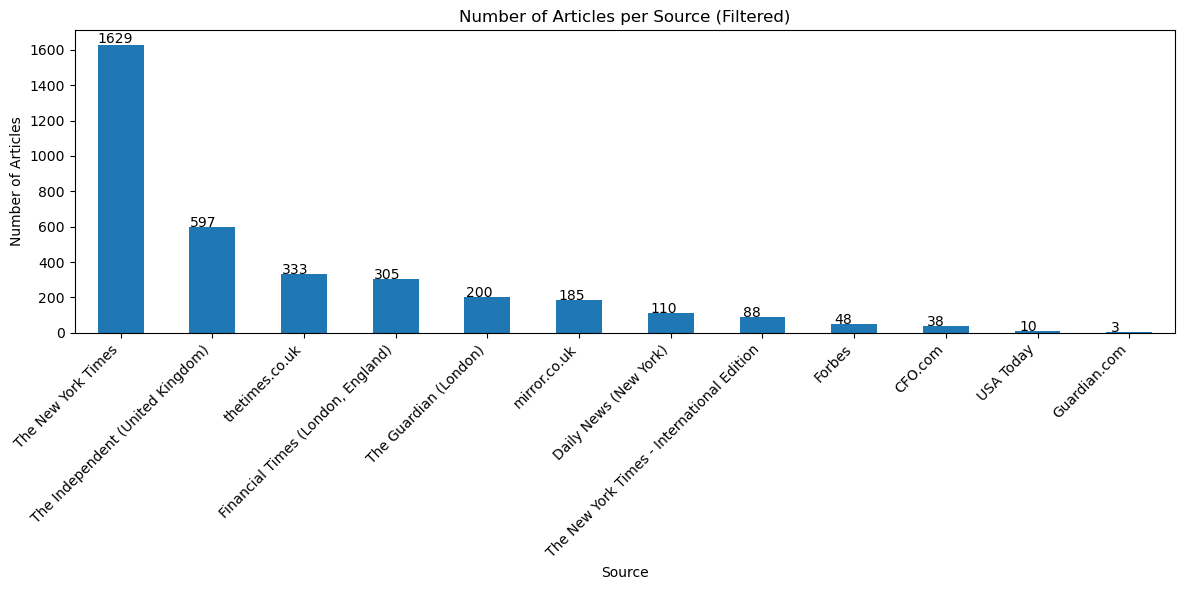

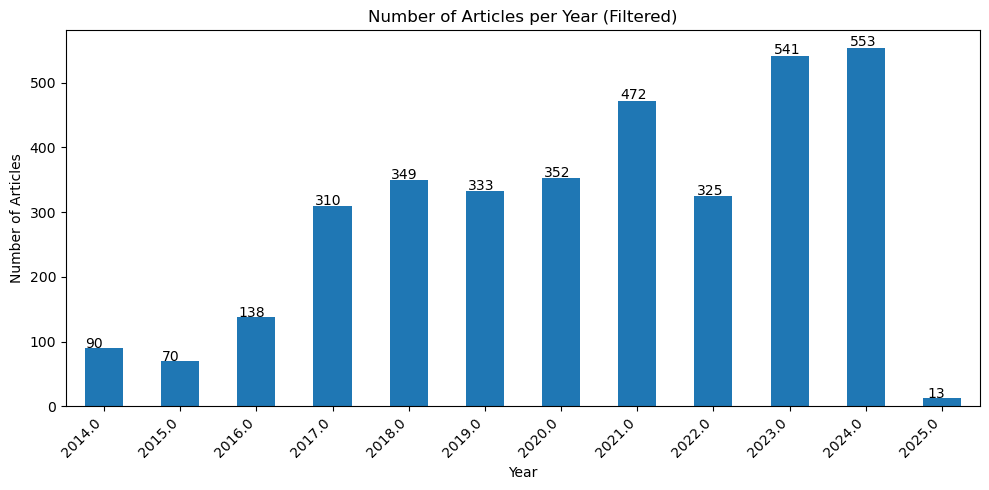

In [ ]:
# Descriptive statistics of article count
article_count = len(df_filtered)
print(f"Total number of articles in filtered dataframe: {article_count}\n")

# Articles per source (filtered)
articles_per_source = df_filtered['Source'].value_counts()
print("Number of articles per source (filtered):")
print(articles_per_source)
print("\n")

# Articles per year (filtered)
articles_per_year = df_filtered['Year'].value_counts().sort_index()
print("Number of articles per year (filtered):")
print(articles_per_year)
print("\n")

# Calculate mean and related statistics for articles per year
mean_articles_per_year = articles_per_year.mean()
median_articles_per_year = articles_per_year.median()
std_articles_per_year = articles_per_year.std()

print("Statistics for articles per year:")
print(f"Mean: {mean_articles_per_year:.2f}")
print(f"Median: {median_articles_per_year:.2f}")
print(f"Standard Deviation: {std_articles_per_year:.2f}")
print("\n")

# Visual graph of articles per source
ax = articles_per_source.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Articles per Source (Filtered)')
plt.xlabel('Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add the value on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

# Visual graph of articles per year
ax = articles_per_year.plot(kind='bar', figsize=(10, 5))
plt.title('Number of Articles per Year (Filtered)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add the value on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

### Step 6 : Creation of the Stopword list

Initially this list is empty and only the NLTK stopwords are used. The list is created iteratively by multiple analysis of the topic modelling. 

In [12]:
custom_stopwords = {
    # Very high frequency, low descriptive value verbs
    "say", "tell", "make", "get", "go", "take", "come", "see", "know", "think",
    "want", "use", "find", "give", "ask", "call", "try", "look", "seem", "believe",
    "start", "set", "put", "add", "move", "include", "offer", "present", "return",
    "leave", "remain", "join", "attend", "work", "write", "become", "appear",
    "respond", "decide", "hold", "raise", "pick", "replace", "buy", "describe",
    "post", "joke", "echo", "watch", "film", 
    "serve", "push", "embrace", "argue", "seek", "bring", "succeed", "donate",
    # ---------------
    "bother", "build", "oust", "recall", "spend", "decline", "reveal", "draw",
    "name", "reassure", "testify", "create", "oversee", "walk", "invest",
    "also", "still", "later", "back", "early", "often", "far", "shortly", "ago",
    "recently", "long", "old", "continue", "consider", "found", "stand", "reach", "step", "grow", "drop",
    "retain", "begin", "reply", "keep", "hope", "sell", "meet",
    "issue", "point", "read", "address", "agree", "send", "receive", "talk",
    "need", "feel", "expect", "pull", "speak", "turn", "show", "like", "involve",
    "lead", "suggest", "sit", "hand", "discuss", "promise", "bear", "thank",
    "welcome", "develop", "follow", "indicate", "run", "note", "pay", "play",
    #------------------
    "claim", "lose", "mention", "already", "reportedly", "however", "previously", "first", 
    "continue", "consider", "found", "stand", "reach", "grow", "drop", "retain",
    "begin", "reply", "keep", "hope", "sell", "meet", "issue",
    "point", "read", "address", "agree", "send", "receive", "talk", "need",
    "feel", "expect", "pull", "turn", "show", "like", "involve", "sit", "hand",
    "discuss", "promise", "bear", "thank", "welcome", "develop", "follow",
    "indicate", "run", "note", "pay", "play", "claim", "lose", "mention",
    # ------------------------
    "visit", "lay","ahead", "ultimately", "well", "publicly", "however", "even", "next",
    "effectively", "quickly", "instead", "away", "ever", "really", "immediately",
    "person", "company", "man", "son", "zuckerberg", "khosla", "figure", "public", "sundar", "arnault", "live", "answer", 
    "compare", "introduce", "refer", "hit", "sign", "hint", "enter", "end", "change", "stay", "report", 
    "well", "publicly", "eventually", "simply", "yet", "privately", "quickly", "instead", "immediately",
    "chief", "manager", "deputy", "boss", "director"
    "company", "page", "zuckerberg", "co", "urge", "marry", "remove", "november","earn","learn","satyanadella", "altman", "consultant", "easily", "eat", "brockman", "file", "cite", "easily", "target", 
    "team", "unveil","feature","eld", "count", "largely", "briefly","rank","cook","photograph",
    #---------------------------
    "face","part", "always", "directly", "chair", "stop" , "officer", "wear" ,"onstage", "opt", "indeed","meanwhile","break","interview","email","tweet","die","hail"
    "officer", "executive" ,"chairman","ceo", "president", "investor", "founder", "mcuban"
    "fly","initially","aside","press","center","tap","student","finally","schedule","home","owner","formally","invite","credit","arrive","explain","choose", "though","prepare","close"
    "elonmusk", "currently","provide","hire","inform","drive","publish","pepper","quit", "nadella","share","manage","scion", "graduate","order","tie","brush",
    "prefer","maybe","fail","paint","require", "estimate","together", "tout", "purchase", "closely", "since", "quote", "bachachan", 
     "clearly","hail","state","sama", "actually", "texte", "host", "may","product", "deal", "express","emerge", "investments",
     #---------------------------
    "allude", "strike", "grant", "throw", "love", "hear", "act", "apply", "regard", "maintain", "spot", "repeat", "court", "race", 
    "gather", "cause", "open", "wait", "rely", "rise", "catch", "delay", "round", "approach", "contact", "float", "spin", 
    "much", "regularly", "enough", "reckon", "afterward", "company", "designer", 
    "gates", "bezos", "zuckerberg", "page", "musk", "dorsey", "khosla", "pichai","alphabet","april","zaslav","fink","link", "february",
    #--------------------------
    "company", "native", "parent", "designer", "gates", "bezos", "zuckerberg","page", "musk", "dorsey", "khosla", "timcook",
     "hear","prove", "complain", "regard", "maintain", "spot", "repeat", "court", "race",
    "gather", "cause", "open", "wait", "rely", "contact", "float", "invoke", "shift", "spin", "pass",
    "throng", "act", "mean", "cook", "live" 
}
print(len(custom_stopwords))

nltk_stopwords = set(stopwords.words('english'))
full_stopwords = set(string.punctuation).union(nltk_stopwords)
full_stopwords = full_stopwords.union(custom_stopwords)
print(len(full_stopwords))

355
585


### Step 7 : Transform the extracted text from the dataframe into a list
The type of the extracted text in the dataframe is <pandas.series> and to run the topic model it would be more better with a unicode list. 

In [24]:
df_filtered['extracted_text_unicode'] = df_filtered['Extracted_Text'].apply(lambda x: u"{}".format(x) if isinstance(x, str) else x)
print(df_filtered['extracted_text_unicode'].head())
print(len(df_filtered['extracted_text_unicode']))
print(df_filtered['CEO_Name'].unique())
print(df_filtered.columns)

0    POPULATION: 6.8 MILLION 2015 GROSS STATE PRODU...
3    The telephone would often ring at dinnertime i...
4    Two portfolio managers were forced to leave th...
5    It also marks the return, in sixth place, of t...
6    If ever someone was born to do a job, it is Fi...
Name: extracted_text_unicode, dtype: object
3546
['Abigail Johnson' 'Akio Toyoda' 'Albert Bourla' 'Alex Karp' 'Ana Botin'
 'Andrew Witty' 'Andy Jassy' 'Benoit Potier ' 'Bernard Arnault'
 'Bill Gates' 'Bob Iger' 'Brian Armstrong' 'Brian Chesky' 'Brian Moynihan'
 'Brian niccol' 'Bruce Flatt' 'Carlos Tavares' 'Carol Tome' 'Charles Koch'
 'Cristiano Amon' 'Dara Khosrowshahi' 'Darren Woods' 'David Solomon'
 'David ricks' 'Doug Mcmillon' 'Elon Musk' 'Fabrizio Freda'
 'Francois Pinault' 'Greg Peters' 'Hamid Ulukaya' 'James Dimon'
 'James Dyson' 'Jane Fraser' 'Jeff Bezos' 'Jen-Hsun Huang' 'John Collison'
 'Julie Sweet' 'Ken Griffin' 'Larry Page' 'Laurence Fink' 'Lawrence Culp'
 'Lawrence Ellison' 'Lee-Jae Yong' 'Lei Jun' 'L

In [ ]:
extracted_text = []
for source in source_list:
    temp = df[df['Source'] == source]  # Remove unnecessary .format()
    extracted_text.append(temp['Extracted_Text'].tolist())

# Flatten the extracted_text list to get all articles in one list
extracted_text = [article for sublist in extracted_text for article in sublist]

# Don't redefine ceo_name since it's already defined

print(f"Total articles extracted: {len(extracted_text)}")
# print(f"First 5 articles preview:")
# for i, article in enumerate(extracted_text[:5]):
#     print(f"Article {i+1}: {article[:200]}...")  # Show first 200 characters

extracted_text_unicode = []

for text in extracted_text:
    unicode = u"{}".format(text)
    extracted_text_unicode.append(unicode)
print(extracted_text_unicode[:5])  # Show first 5 unicode articles

ceo_name = df['CEO_Name'].unique().tolist()

Total articles extracted: 3546
["POPULATION: 6.8 MILLION 2015 GROSS STATE PRODUCT: $477 billion (2% GROWTH) GSP PER CAPITA: $70,167 (RANKS NO. 6 NATIONWIDE) RICHEST: ABIGAIL JOHNSON, $14.3 BILLION IN DECEMBER Abigail Johnson, 55, took full command of her family's Boston-based Fidelity Investments, adding the chairman title her father held for nearly four decades to the CEO job she has done since 2014. With $2.1 trillion under management and $5.6 trillion under administration, Fidelity is the world's fourth-largest asset mana\xadger and the U.S.' top 401(k) administrator. But Johnson, a Harvard M.B.A. who joined Fidelity as an analyst in 1988, must execute a tricky balancing act to protect its margins and market share. The firm built its reputation with actively managed mutual funds (think Peter Lynch and Magellan). Yet investors have been moving to low-cost, market-tracking index funds. In July Johnson dropped fees on 27 index funds and ETFs, in some cases undercutting Vanguard, the in

### Step 8 : Main analysis Code

The code is the main which uses the <extracted_text_unicode> list to do initial preprocessing, tokenisation, deduplication, topic modelling, verification of other topic modelling.  

In [42]:
# 1. Import necessary libraries
import spacy
from spacy import displacy

# Define the model name to be used.
# en_core_web_lg is a large English model with word vectors.
SPACY_MODEL = "en_core_web_lg"

# 2. Load the spaCy language model
# This block checks if the model is installed and downloads it if necessary.
# The model contains the vocabulary, syntax, and other data needed to process text.
print(f"Loading spaCy model '{SPACY_MODEL}'...")
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Model '{SPACY_MODEL}' not found. Downloading...")
    # The spacy.cli.download function is used to download models from the command line,
    # but we can call it from Python as well.
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)
print("Model loaded successfully.")

# 3. The text to be analyzed
text = "The pandemic forced Mr. Woods to change direction."

# 4. Process the text with the spaCy NLP pipeline
# This creates a `Doc` object, which is a container for a sequence of tokens
# and all of their linguistic annotations (like part-of-speech tags and dependencies).
doc = nlp(text)

# 5. Start the displaCy web server to visualize the dependency parse
# The displacy.serve() function starts a local web server.
# - style='dep' specifies that we want a dependency parse visualization.
# - auto_select_port=True will automatically find an available port if the default (5000) is busy.
print("\nStarting displaCy server...")
print("Copy the URL from the console and open it in your browser to see the visualization.")
print("Stop the script with Ctrl+C in your terminal to shut down the server.")

displacy.serve(doc, style='dep', auto_select_port=True)

Loading spaCy model 'en_core_web_lg'...
Model loaded successfully.

Starting displaCy server...
Copy the URL from the console and open it in your browser to see the visualization.
Stop the script with Ctrl+C in your terminal to shut down the server.



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


In [43]:
# 1. Import necessary libraries
import spacy
from spacy import displacy
import threading
import time

# Define the model name to be used.
# en_core_web_lg is a large English model with word vectors.
SPACY_MODEL = "en_core_web_lg"

# 2. Load the spaCy language model
# This block checks if the model is installed and downloads it if necessary.
# The model contains the vocabulary, syntax, and other data needed to process text.
print(f"Loading spaCy model '{SPACY_MODEL}'...")
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Model '{SPACY_MODEL}' not found. Downloading...")
    # The spacy.cli.download function is used to download models from the command line,
    # but we can call it from Python as well.
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)
print("Model loaded successfully.")

# 3. The text to be analyzed
text = "The pandemic forced Mr. Woods to change direction."

# 4. Process the text with the spaCy NLP pipeline
# This creates a `Doc` object, which is a container for a sequence of tokens
# and all of their linguistic annotations (like part-of-speech tags and dependencies).
doc = nlp(text)

# 5. Define functions to start the servers
# We run each server in a separate thread so they can run at the same time.
def serve_dependency_parse():
    """Serves the dependency parse visualization."""
    print("\nStarting server for Dependency Parse (dep)...")
    # style='dep' is for dependency parsing
    displacy.serve(doc, style='dep', auto_select_port=True)

def serve_ner():
    """Serves the Named Entity Recognition visualization."""
    print("\nStarting server for Named Entity Recognition (ent)...")
    # style='ent' is for Named Entity Recognition
    displacy.serve(doc, style='ent', auto_select_port=True)

# 6. Create and start the threads
dep_thread = threading.Thread(target=serve_dependency_parse)
ner_thread = threading.Thread(target=serve_ner)

# Set threads as daemon so they will exit when the main program exits
dep_thread.daemon = True
ner_thread.daemon = True

dep_thread.start()
ner_thread.start()

# 7. Keep the main script running
print("\nTwo servers are starting on different ports.")
print("Copy the URLs from the console and open them in your browser.")
print("Stop the script with Ctrl+C in your terminal to shut down the servers.")

try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nShutting down servers.")


Loading spaCy model 'en_core_web_lg'...
Model loaded successfully.

Starting server for Dependency Parse (dep)...

Starting server for Named Entity Recognition (ent)...

Two servers are starting on different ports.
Copy the URLs from the console and open them in your browser.
Stop the script with Ctrl+C in your terminal to shut down the servers.


/opt/anaconda3/lib/python3.10/site-packages/spacy/util.py:1846: UserWarning: [W124] 0.0.0.0:5000 is already in use, using the nearest available port 5002 as an alternative.
  warnings.warn(Warnings.W124.format(host=host, port=start, serve_port=port))



Using the 'ent' visualizer
Serving on http://0.0.0.0:5002 ...


Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...


Shutting down servers.


In [27]:
import pandas as pd
import spacy
import re
import string
from typing import List, Dict, Tuple, Set
from nltk.corpus import stopwords
import nltk # Added import for NLTK download check

# --- Setup: Load spaCy Model and Stopwords ---
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("SpaCy model 'en_core_web_lg' not found. Please run: python -m spacy download en_core_web_lg")
    exit()

try:
    nltk_stopwords = set(stopwords.words('english'))
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    nltk_stopwords = set(stopwords.words('english'))


# --- Helper Functions (No changes needed here) ---
def _is_token_related_to_target_person_as_subject_or_object(
    token, sentence_person_entities: List[spacy.tokens.Span], subject_deps: Set[str], object_deps: Set[str]
) -> bool:
    for child in token.children:
        if child.dep_ in subject_deps:
            for person_ent in sentence_person_entities:
                if child.i >= person_ent.start and child.i < person_ent.end:
                    return True
    for child in token.children:
        if child.dep_ in object_deps:
            for person_ent in sentence_person_entities:
                if child.i >= person_ent.start and child.i < person_ent.end:
                    return True
    return False

def _is_adjective_modifying_target_person(
    adj_token, sentence_person_entities: List[spacy.tokens.Span], adjectival_deps: Set[str]
) -> bool:
    if adj_token.dep_ in adjectival_deps:
        head_token = adj_token.head
        for person_ent in sentence_person_entities:
            if head_token.i >= person_ent.start and head_token.i < person_ent.end:
                return True
    return False

def _is_noun_describing_target_person(
    noun_token, sentence_person_entities: List[spacy.tokens.Span]
) -> bool:
    if noun_token.dep_ == "appos":
        head_token = noun_token.head
        for person_ent in sentence_person_entities:
            if head_token.i >= person_ent.start and head_token.i < person_ent.end:
                return True
    if noun_token.dep_ == "attr" and noun_token.head.pos_ == "VERB":
        verb_head = noun_token.head
        for child_of_verb in verb_head.children:
            if child_of_verb.dep_ in {"nsubj", "nsubjpass"}:
                for person_ent in sentence_person_entities:
                    if child_of_verb.i >= person_ent.start and child_of_verb.i < person_ent.end:
                        return True
    return False


# --- Main Preprocessing Function ---
# CHANGED: The function now accepts a DataFrame instead of a list of strings.
def run_preprocessing_pipeline(
    articles_df: pd.DataFrame,
    text_column: str,
    year_column: str,
    my_target_people: List[str],
    my_stopwords: Set[str],
    min_sentence_length: int = 1,
) -> pd.DataFrame:
    """
    Runs the full preprocessing pipeline on raw articles from a DataFrame.
    Returns a DataFrame containing original sentence, preprocessed sentence, and year.
    """
    print("--- Initial Sentence Extraction and Robust Deduplication ---")
    
    # CHANGED: Iterate through the DataFrame to access text and year together.
    all_raw_sentences_with_metadata = []
    for index, row in articles_df.iterrows():
        article_text = str(row[text_column])
        year = row[year_column] # Get the year from the same row.
        doc = nlp(article_text)
        for sent in doc.sents:
            # Store the sentence text and its associated year as a tuple.
            all_raw_sentences_with_metadata.append((sent.text, year))

    print(f"Total sentences extracted: {len(all_raw_sentences_with_metadata)}")

    # CHANGED: Deduplication now works with tuples (sentence, year).
    unique_cleaned_sentences_with_metadata = []
    seen_exact_fingerprints = set()
    
    for sent_text, year in all_raw_sentences_with_metadata:
        normalized_words_for_fingerprint = sorted([
            token.text.lower() for token in nlp(sent_text)
            if not token.is_punct and not token.is_digit and token.text.strip() != ""
        ])
        string_fingerprint = " ".join(normalized_words_for_fingerprint)

        if string_fingerprint in seen_exact_fingerprints:
            continue
        
        seen_exact_fingerprints.add(string_fingerprint)
        # Keep the sentence and its year together.
        unique_cleaned_sentences_with_metadata.append((sent_text.strip(), year))

    print(f"Total unique sentences after deduplication: {len(unique_cleaned_sentences_with_metadata)}")

    print("\nStarting detailed preprocessing with dependency parsing...")
    
    target_last_name_to_full_name = {name.split()[-1].lower(): name for name in my_target_people}
    adjectival_deps = {"amod"}
    subject_deps = {"nsubj", "nsubjpass"}
    object_deps = {"dobj", "pobj"}
    adverbial_deps = {"advmod"}
    temp_person_centric_sentences_data = []

    # CHANGED: Loop through unique sentences *and* their associated years.
    for raw_sentence_text, year in unique_cleaned_sentences_with_metadata:
        doc = nlp(raw_sentence_text)
        sentence = list(doc.sents)[0] 
        persons_in_this_sentence = set()
        sentence_person_entities = []

        for ent in sentence.ents:
            if ent.label_ == "PERSON":
                ent_last_name = ent.text.split()[-1].lower()
                if ent_last_name in target_last_name_to_full_name:
                    canonical_name = target_last_name_to_full_name[ent_last_name]
                    persons_in_this_sentence.add(canonical_name)
                    sentence_person_entities.append(ent)

        if not persons_in_this_sentence:
            continue

        processed_tokens = []
        # (Rest of the token processing logic is the same)
        for token in sentence:
            lemma = token.lemma_.lower()
            clean_lemma = re.sub(r'[^a-z]', '', lemma)
            if not clean_lemma or clean_lemma in my_stopwords or token.is_punct or token.is_digit:
                continue
            if token.pos_ == "ADJ" and _is_adjective_modifying_target_person(token, sentence_person_entities, adjectival_deps):
                processed_tokens.append(clean_lemma)
            elif token.pos_ == "VERB" and _is_token_related_to_target_person_as_subject_or_object(token, sentence_person_entities, subject_deps, object_deps):
                processed_tokens.append(clean_lemma)
            elif token.pos_ == "ADV" and token.dep_ in adverbial_deps:
                head_token = token.head
                if head_token.pos_ == "VERB" and _is_token_related_to_target_person_as_subject_or_object(head_token, sentence_person_entities, subject_deps, object_deps):
                    processed_tokens.append(clean_lemma)
                elif head_token.pos_ == "ADJ" and _is_adjective_modifying_target_person(head_token, sentence_person_entities, adjectival_deps):
                    processed_tokens.append(clean_lemma)
            elif token.pos_ in {"NOUN", "PROPN"} and _is_noun_describing_target_person(token, sentence_person_entities):
                processed_tokens.append(clean_lemma)

        if len(processed_tokens) >= min_sentence_length:
            preprocessed_sentence_str = " ".join(processed_tokens)
            for person_name in persons_in_this_sentence:
                # CHANGED: Add the 'Year' to the dictionary here.
                temp_person_centric_sentences_data.append({
                    'person_name': person_name,
                    'original_sentence': raw_sentence_text,
                    'preprocessed_tokens_str': preprocessed_sentence_str,
                    'Year': year 
                })
    
    final_preprocessed_data = []
    seen_final_original_sentences_for_df = set()

    for item in temp_person_centric_sentences_data:
        if item['original_sentence'] not in seen_final_original_sentences_for_df:
            seen_final_original_sentences_for_df.add(item['original_sentence'])
            final_preprocessed_data.append(item)

    df = pd.DataFrame(final_preprocessed_data)
    print("\nPreprocessing complete. Data prepared for export.")
    return df

if __name__ == "__main__":
    # --- Load your main DataFrame here ---
    # This assumes 'df_filtered' is already loaded and contains the necessary columns.
    # For demonstration, let's create a dummy df_filtered.
    # Replace this with loading your actual data, e.g., df_filtered = pd.read_csv('your_data.csv')

    # --- Configuration ---
    my_target_people = df_filtered['CEO_Name'].unique()
    my_stopwords = nltk_stopwords.union(custom_stopwords)

    # CHANGED: Call the function with the DataFrame and column names.
    preprocessed_df = run_preprocessing_pipeline(
        articles_df=df_filtered,
        text_column='extracted_text_unicode',
        year_column='Year',
        my_target_people=my_target_people,
        my_stopwords=my_stopwords,
    )

    # The resulting DataFrame now includes the 'Year' column.
    print("\nPreview of the final preprocessed DataFrame:")
    print(preprocessed_df.head())

    # Save the DataFrame for use in other code blocks
    preprocessed_df.to_csv('preprocessed_sentences_final.csv', index=False)
    print("\nPreprocessed sentences saved to 'preprocessed_sentences_final.csv'")

--- Initial Sentence Extraction and Robust Deduplication ---
Total sentences extracted: 58089
Total unique sentences after deduplication: 53854

Starting detailed preprocessing with dependency parsing...

Preprocessing complete. Data prepared for export.

Preview of the final preprocessed DataFrame:
       person_name                                  original_sentence  \
0  Abigail Johnson  But Johnson, a Harvard M.B.A. who joined Fidel...   
1  Abigail Johnson  Now the family business is hers , and Ms Johns...   
2  Abigail Johnson  When Edward "Ned" Johnson relinquished the chi...   
3  Abigail Johnson         That is a pose that has suited Ms Johnson.   
4  Abigail Johnson  One by one, Ms Johnson has supplanted veteran ...   

  preprocessed_tokens_str    Year  
0             mba execute  2017.0  
1                  assume  2014.0  
2              relinquish  2014.0  
3                    suit  2014.0  
4                supplant  2014.0  

Preprocessed sentences saved to 'preprocess

Data loaded successfully.
Preparing Gensim corpus...

--- Starting Topic Model Tuning ---
Training and evaluating model with 5 topics...
Training and evaluating model with 10 topics...
Training and evaluating model with 15 topics...
Training and evaluating model with 20 topics...
Training and evaluating model with 25 topics...
Training and evaluating model with 30 topics...

Showing plot. Please close the plot window to continue...


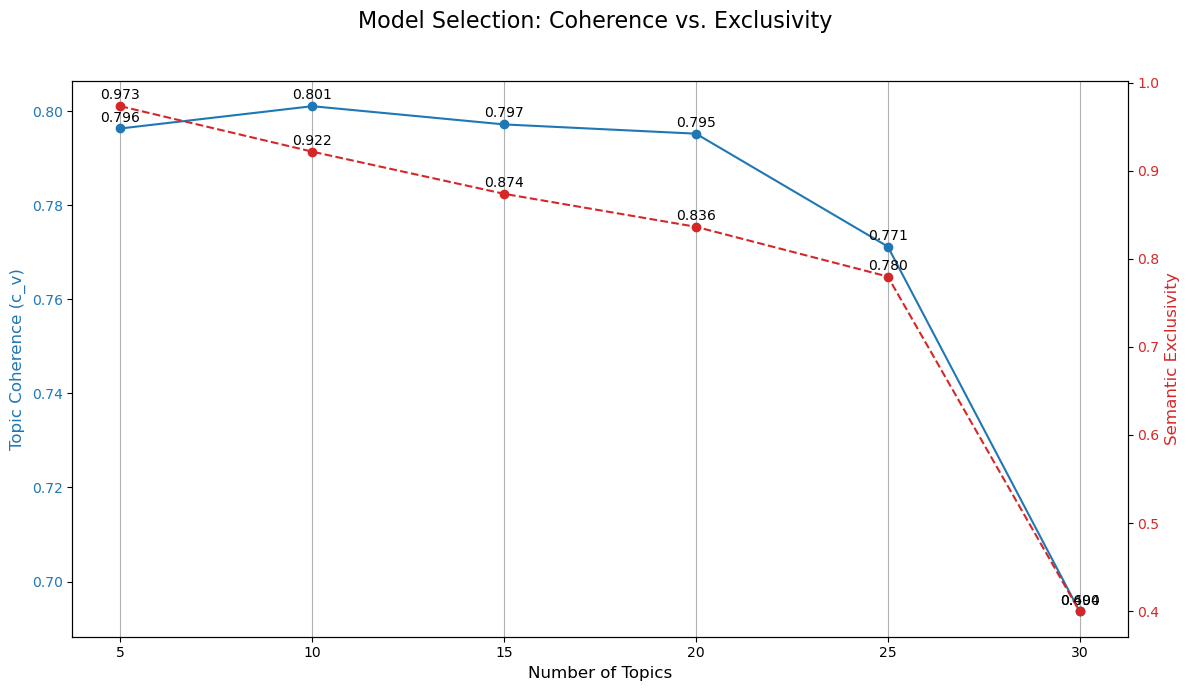


Proceeding with 10 topics for the final models.

--- Running Final LDA Model ---
Assigning dominant topics to sentences...
Exporting consolidated LDA results...
✅ Final LDA results exported to single files in 'topic_model_outputs/lda_results' directory.

--- Running Validation Models (LSI & NMF) ---
✅ LSI and NMF validation topics exported.

🎉 All processes complete.


In [31]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, LsiModel, Nmf, CoherenceModel
import os
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
INPUT_FILE = '/Users/shantanusharma/Desktop/preprocessed_sentences_final.csv'
OUTPUT_DIR = 'topic_model_outputs'
NUM_REPRESENTATIVE_SENTENCES = 10
NUM_TOPIC_WORDS = 15

# --- Create Output Directories ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
if not os.path.exists(os.path.join(OUTPUT_DIR, 'lda_results')):
    os.makedirs(os.path.join(OUTPUT_DIR, 'lda_results'))
if not os.path.exists(os.path.join(OUTPUT_DIR, 'validation_models')):
    os.makedirs(os.path.join(OUTPUT_DIR, 'validation_models'))

# --- Load Data ---
try:
    df = pd.read_csv(INPUT_FILE)
except FileNotFoundError:
    print(f"Error: '{INPUT_FILE}' not found. Please check the file path.")
    exit()

if df.empty:
    print("No data in the preprocessed DataFrame. Exiting.")
    exit()

print("Data loaded successfully.")
all_preprocessed_sentences_tokenized = [s.split() for s in df['preprocessed_tokens_str'].tolist()]
original_sentence_col = 'original_sentence'

# --- Prepare Gensim Corpus ---
print("Preparing Gensim corpus...")
dictionary = Dictionary(all_preprocessed_sentences_tokenized)
dictionary.filter_extremes(no_below=1, no_above=0.9, keep_n=100000)
bow_corpus = [dictionary.doc2bow(text) for text in all_preprocessed_sentences_tokenized]
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

# =========================================================================== #
# 1. INTERACTIVE MODEL TUNING
# =========================================================================== #
print("\n--- Starting Topic Model Tuning ---")

def calculate_exclusivity(model, dictionary, top_n_words=10):
    """Calculates topic exclusivity."""
    exclusivity_scores = []
    topics = model.get_topics()
    for topic_index in range(model.num_topics):
        top_word_indices = np.argsort(topics[topic_index])[-top_n_words:]
        topic_exclusivity = 0
        for word_index in top_word_indices:
            p_word_in_topic = topics[topic_index, word_index]
            p_word_in_all_topics = np.sum(topics[:, word_index])
            if p_word_in_all_topics > 1e-9:
                topic_exclusivity += p_word_in_topic / p_word_in_all_topics
        exclusivity_scores.append(topic_exclusivity / top_n_words)
    return np.mean(exclusivity_scores)

topic_range = range(5, 31, 5)
coherence_scores = []
exclusivity_scores = []

for k in topic_range:
    print(f"Training and evaluating model with {k} topics...")
    lda_model_temp = LdaModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence_model = CoherenceModel(model=lda_model_temp, texts=all_preprocessed_sentences_tokenized, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())
    exclusivity_scores.append(calculate_exclusivity(lda_model_temp, dictionary))

# --- Plotting with Dual-Axis Line Graph ---
fig, ax1 = plt.subplots(figsize=(12, 7))
color1 = 'tab:blue'
ax1.set_xlabel('Number of Topics', fontsize=12)
ax1.set_ylabel('Topic Coherence (c_v)', color=color1, fontsize=12)
ax1.plot(topic_range, coherence_scores, 'o-', color=color1, label='Coherence')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(axis='x')
for i, txt in enumerate(coherence_scores):
    ax1.annotate(f'{txt:.3f}', (list(topic_range)[i], coherence_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Semantic Exclusivity', color=color2, fontsize=12)
ax2.plot(topic_range, exclusivity_scores, 'o--', color=color2, label='Exclusivity')
ax2.tick_params(axis='y', labelcolor=color2)
for i, txt in enumerate(exclusivity_scores):
    ax2.annotate(f'{txt:.3f}', (list(topic_range)[i], exclusivity_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')

fig.suptitle('Model Selection: Coherence vs. Exclusivity', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
print("\nShowing plot. Please close the plot window to continue...")
plt.show()

# --- User Input for Final Model ---
while True:
    try:
        NUM_TOPICS = int(input(f"\nBased on the plot, please enter the final number of topics to use (e.g., from {list(topic_range)}): "))
        if NUM_TOPICS in topic_range:
            break
        else:
            print(f"Invalid input. Please choose a number from the tested range: {list(topic_range)}")
    except ValueError:
        print("Invalid input. Please enter an integer.")

print(f"\nProceeding with {NUM_TOPICS} topics for the final models.")

# =========================================================================== #
# 2. FINAL LDA (Latent Dirichlet Allocation)
# =========================================================================== #
print("\n--- Running Final LDA Model ---")

final_lda_model = LdaModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=NUM_TOPICS, passes=20, random_state=42, alpha='auto', eta='auto')
print("Assigning dominant topics to sentences...")
df['Topic'] = [max(final_lda_model[doc], key=lambda x: x[1])[0] if doc else -1 for doc in tfidf_corpus]
df['Topic_Probability'] = [max(final_lda_model[doc], key=lambda x: x[1])[1] if doc else 0.0 for doc in tfidf_corpus]

# --- Consolidating LDA results into single files ---
print("Exporting consolidated LDA results...")
all_topic_words = []
all_rep_sentences = []

for topic_id in range(final_lda_model.num_topics):
    topic_words = final_lda_model.show_topic(topic_id, topn=NUM_TOPIC_WORDS)
    words_df = pd.DataFrame(topic_words, columns=['Word', 'Weight'])
    words_df['Topic_ID'] = topic_id
    all_topic_words.append(words_df)

    rep_docs_df = df[df['Topic'] == topic_id].sort_values(by='Topic_Probability', ascending=False).head(NUM_REPRESENTATIVE_SENTENCES)
    all_rep_sentences.append(rep_docs_df)

final_words_df = pd.concat(all_topic_words, ignore_index=True)
final_sentences_df = pd.concat(all_rep_sentences, ignore_index=True)

# --- NEW: Explicitly select and order columns for the sentences CSV ---
# Define the columns you want in the final output file.
# This ensures 'Year' and 'CEO_Name' are included.
columns_to_save = [
    original_sentence_col,
    'Topic',
    'Topic_Probability',
    'person_name',
    'Year'
]
# Filter the DataFrame to only include these columns before saving.
final_sentences_df_to_save = final_sentences_df[columns_to_save]

final_words_df.to_csv(os.path.join(OUTPUT_DIR, 'lda_results', 'lda_all_topic_words.csv'), index=False)
final_sentences_df_to_save.to_csv(os.path.join(OUTPUT_DIR, 'lda_results', 'lda_all_representative_sentences.csv'), index=False)
print(f"✅ Final LDA results exported to single files in '{os.path.join(OUTPUT_DIR, 'lda_results')}' directory.")


# =========================================================================== #
# 3. LSI & NMF (For Validation)
# =========================================================================== #
print("\n--- Running Validation Models (LSI & NMF) ---")
lsi_model = LsiModel(corpus=tfidf_corpus, id2word=dictionary, num_topics=NUM_TOPICS)
nmf_model = Nmf(corpus=tfidf_corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42)
lsi_topics = [{'Topic_ID': i, 'Word': w, 'Weight': s} for i in range(NUM_TOPICS) for w, s in lsi_model.show_topic(i, topn=NUM_TOPIC_WORDS)]
nmf_topics = [{'Topic_ID': i, 'Word': w, 'Weight': s} for i in range(NUM_TOPICS) for w, s in nmf_model.show_topic(i, topn=NUM_TOPIC_WORDS)]
pd.DataFrame(lsi_topics).to_csv(os.path.join(OUTPUT_DIR, 'validation_models', 'lsi_topics.csv'), index=False)
pd.DataFrame(nmf_topics).to_csv(os.path.join(OUTPUT_DIR, 'validation_models', 'nmf_topics.csv'), index=False)
print(f"✅ LSI and NMF validation topics exported.")

print("\n🎉 All processes complete.")

In [25]:
import pandas as pd

# --- Configuration ---
# 1. The CSV file containing the topic information from your last run.
TOPICS_FILE = '/Users/shantanusharma/Desktop/topic_model_outputs/lda_results/lda_all_representative_sentences.csv'

# 2. The path to your main DataFrame file that has the 'Extracted_text' column.
# !!! IMPORTANT: Please update this path to point to your actual file.
FILTERED_DF_FILE = df_filtered 

# 3. The name of the final output file.
OUTPUT_FILE = 'df_filtered_with_topics.csv'

# --- Load the DataFrames ---
try:
    print(f"Loading representative sentences from '{TOPICS_FILE}'...")
    topics_df = pd.read_csv(TOPICS_FILE)

    print(f"Loading main filtered DataFrame from '{FILTERED_DF_FILE}'...")
    df_filtered = FILTERED_DF_FILE
except FileNotFoundError as e:
    print(f"Error: Could not find a file. Please check your file paths.")
    print(e)
    exit()

# --- Prepare Data for Merging ---
# We only need the sentence, topic, and probability columns from the topics file.
# This avoids adding duplicate columns like 'Year'.
columns_to_merge = ['original_sentence', 'Topic', 'Topic_Probability']
topics_to_add = topics_df[columns_to_merge]

print("\nData loaded. Starting merge process...")
print(f"Original shape of df_filtered: {df_filtered.shape}")
print(f"Shape of topics_df: {topics_to_add.shape}")

# --- Perform the Merge ---
# We use a 'left' merge to keep all rows from df_filtered.
# Topic information will be added where the sentences match.
# If a sentence in df_filtered has no match in topics_df, its new columns will be NaN.
merged_df = pd.merge(
    df_filtered,
    topics_to_add,
    left_on='Extracted_Text', # Column name in your main DataFrame
    right_on='original_sentence', # Column name in the topics CSV
    how='left'
)

# --- Clean Up and Verify ---
# The merge creates a duplicate sentence column ('original_sentence'). We can drop it.
merged_df = merged_df.drop(columns=['original_sentence'])

print("\nMerge complete.")
print(f"Shape of new merged DataFrame: {merged_df.shape}")

# Check how many rows successfully received topic information
successful_merges = merged_df['Topic'].notna().sum()
total_rows = len(merged_df)
print(f"\nSuccessfully added topic information to {successful_merges} out of {total_rows} rows.")

# Display the first few rows of the final DataFrame
print("\nPreview of the final DataFrame with added topics:")
print(merged_df.head())

# --- Save the Final DataFrame ---
merged_df.to_csv(OUTPUT_FILE, index=False)
print(f"\n✅ Final DataFrame saved to '{OUTPUT_FILE}'.")

Loading representative sentences from '/Users/shantanusharma/Desktop/topic_model_outputs/lda_results/lda_all_representative_sentences.csv'...
Loading main filtered DataFrame from '             CEO_Name                             Source    Year  \
0     Abigail Johnson                             Forbes  2017.0   
3     Abigail Johnson  Financial Times (London, England)  2014.0   
4     Abigail Johnson                 The New York Times  2018.0   
5     Abigail Johnson                     thetimes.co.uk  2020.0   
6     Abigail Johnson  Financial Times (London, England)  2014.0   
...               ...                                ...     ...   
7241   Warren Buffett                 The New York Times  2022.0   
7247   Warren Buffett  Financial Times (London, England)  2019.0   
7249   Warren Buffett                 The New York Times  2024.0   
7257   Warren Buffett                     thetimes.co.uk  2022.0   
7258   Warren Buffett  Financial Times (London, England)  2019.0   

   

In [9]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel

# --- Configuration ---
INPUT_FILE = '/Users/shantanusharma/Desktop/preprocessed_sentences_final.csv'
OUTPUT_FILE = 'df_with_all_topics.csv'

# IMPORTANT: Use the number of topics you selected from the tuning phase.
FINAL_NUM_TOPICS = 10 

# --- 1. Load Preprocessed Data ---
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"Loaded '{INPUT_FILE}' with {len(df)} sentences.")
except FileNotFoundError:
    print(f"Error: The file '{INPUT_FILE}' was not found.")
    exit()

# --- 2. Prepare Corpus for LDA Model ---
# Create a list of token lists from the 'preprocessed_tokens_str' column
all_tokens = [str(s).split() for s in df['preprocessed_tokens_str']]
dictionary = Dictionary(all_tokens)
bow_corpus = [dictionary.doc2bow(text) for text in all_tokens]
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

print("Corpus prepared for LDA.")

# --- 3. Train the Final LDA Model ---
print(f"Training final LDA model with {FINAL_NUM_TOPICS} topics...")
final_lda_model = LdaModel(
    corpus=tfidf_corpus,
    id2word=dictionary,
    num_topics=FINAL_NUM_TOPICS,
    passes=20,
    random_state=42,
    alpha='auto',
    eta='auto'
)

# --- 4. Assign Dominant Topic to EVERY Sentence ---
print("Assigning dominant topic to all sentences...")
dominant_topics = []
topic_probabilities = []

# Get the topic distribution for each document in the corpus
all_doc_topic_dist = final_lda_model[tfidf_corpus]

for doc_dist in all_doc_topic_dist:
    if doc_dist:
        # Find the topic with the highest probability
        dominant_topic, prob = max(doc_dist, key=lambda x: x[1])
        dominant_topics.append(dominant_topic)
        topic_probabilities.append(prob)
    else:
        # Handle cases where a document might have no topics
        dominant_topics.append(-1) # Placeholder for no topic
        topic_probabilities.append(0.0)

# Add the results as new columns to the original DataFrame
df['Topic'] = dominant_topics
df['Topic_Probability'] = topic_probabilities

print("Topic assignment complete.")

# --- 5. Save the Complete Dataset ---
df.to_csv(OUTPUT_FILE, index=False)
print(f"\n✅ Complete dataset with all topics saved to '{OUTPUT_FILE}'.")
print("\nYou can now use this file for any analysis.")

Loaded '/Users/shantanusharma/Desktop/preprocessed_sentences_final.csv' with 4070 sentences.
Corpus prepared for LDA.
Training final LDA model with 10 topics...
Assigning dominant topic to all sentences...
Topic assignment complete.

✅ Complete dataset with all topics saved to 'df_with_all_topics.csv'.

You can now use this file for any analysis.


In [21]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel
import os

# --- Configuration ---
INPUT_FILE = 'preprocessed_sentences_final.csv'
OUTPUT_DIR = 'topic_model_outputs'
NUM_TOPIC_WORDS = 15 # For file exports

# --- Create Output Directories ---
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
if not os.path.exists(os.path.join(OUTPUT_DIR, 'lda_results')):
    os.makedirs(os.path.join(OUTPUT_DIR, 'lda_results'))

# --- Load Data ---
try:
    df = df
except FileNotFoundError:
    print(f"Error: '{INPUT_FILE}' not found. Please check the file path.")
    exit()

print("Data loaded successfully.")
all_preprocessed_sentences_tokenized = [str(s).split() for s in df['preprocessed_tokens_str']]

# --- Prepare Gensim Corpus ---
print("Preparing Gensim corpus...")
dictionary = Dictionary(all_preprocessed_sentences_tokenized)
dictionary.filter_extremes(no_below=1, no_above=0.9, keep_n=100000)
bow_corpus = [dictionary.doc2bow(text) for text in all_preprocessed_sentences_tokenized]
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

# Use the number of topics you determined from your tuning phase.
NUM_TOPICS = 5
print(f"\nProceeding with {NUM_TOPICS} topics for the final models.")

# =========================================================================== #
# FINAL LDA (Latent Dirichlet Allocation)
# =========================================================================== #
print("\n--- Running Final LDA Model ---")

final_lda_model = LdaModel(
    corpus=tfidf_corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    passes=20,
    random_state=42,
    alpha='auto',
    eta='auto'
)

# --- Assign Topics to DataFrame ---
print("Assigning dominant topics to sentences...")
# (This part can be commented out if you only need to see the topics)
# df['Topic'] = [max(final_lda_model[doc], key=lambda x: x[1])[0] if doc else -1 for doc in tfidf_corpus]
# ...

# --- Display and Export LDA Results ---
print("\n--- LDA Model Results (Gensim Format) ---")

# --- MODIFIED: Display Top 10 Topic Keywords in Gensim Format ---
# You can also use the built-in function for a quick view:
# final_lda_model.print_topics()

for topic_id in range(final_lda_model.num_topics):
    topic_words = final_lda_model.show_topic(topic_id, topn=10)
    # Build the string in the desired format
    topic_string = " + ".join([f'{weight:.3f}*"{word}"' for word, weight in topic_words])
    print(f"Topic #{topic_id}: {topic_string}")
# --- End of Modified Section ---

# --- Exporting to files (optional, can be commented out) ---
# all_topic_words = []
# for topic_id in range(final_lda_model.num_topics):
#     topic_words_for_export = final_lda_model.show_topic(topic_id, topn=NUM_TOPIC_WORDS)
#     words_df = pd.DataFrame(topic_words_for_export, columns=['Word', 'Weight'])
#     words_df['Topic_ID'] = topic_id
#     all_topic_words.append(words_df)
#
# final_words_df = pd.concat(all_topic_words, ignore_index=True)
# final_words_df.to_csv(os.path.join(OUTPUT_DIR, 'lda_results', 'lda_all_topic_words.csv'), index=False)
# print(f"\n✅ Final LDA topic words also exported to a file.")

Data loaded successfully.
Preparing Gensim corpus...

Proceeding with 5 topics for the final models.

--- Running Final LDA Model ---
Assigning dominant topics to sentences...

--- LDA Model Results (Gensim Format) ---
Topic #0: 0.035*"admit" + 0.023*"expand" + 0.021*"toss" + 0.021*"gleefully" + 0.021*"shun" + 0.021*"eschew" + 0.021*"miss" + 0.021*"philanthropist" + 0.015*"sister" + 0.015*"survive"
Topic #1: 0.047*"acknowledge" + 0.042*"predict" + 0.031*"promote" + 0.028*"repeatedly" + 0.026*"sound" + 0.025*"laugh" + 0.024*"force" + 0.024*"limit" + 0.023*"rightly" + 0.023*"entrust"
Topic #2: 0.047*"defend" + 0.046*"head" + 0.039*"billionaire" + 0.033*"confront" + 0.032*"win" + 0.028*"advise" + 0.027*"prompt" + 0.025*"elevate" + 0.022*"help" + 0.022*"accuse"
Topic #3: 0.046*"praise" + 0.030*"dismiss" + 0.026*"question" + 0.026*"leader" + 0.026*"emphasize" + 0.025*"fire" + 0.024*"struggle" + 0.022*"worth" + 0.022*"label" + 0.022*"perfect"
Topic #4: 0.062*"announce" + 0.044*"warn" + 0.027

Successfully loaded the complete topic dataset.

Core analysis complete. Total prevalence calculated for all clusters, people, and years.

--- Generating Longitudinal Trend Graph ---


/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

✅ Longitudinal plot saved.

--- Generating 2023 Snapshot Bubble Chart ---
✅ 2023 snapshot bubble chart saved.


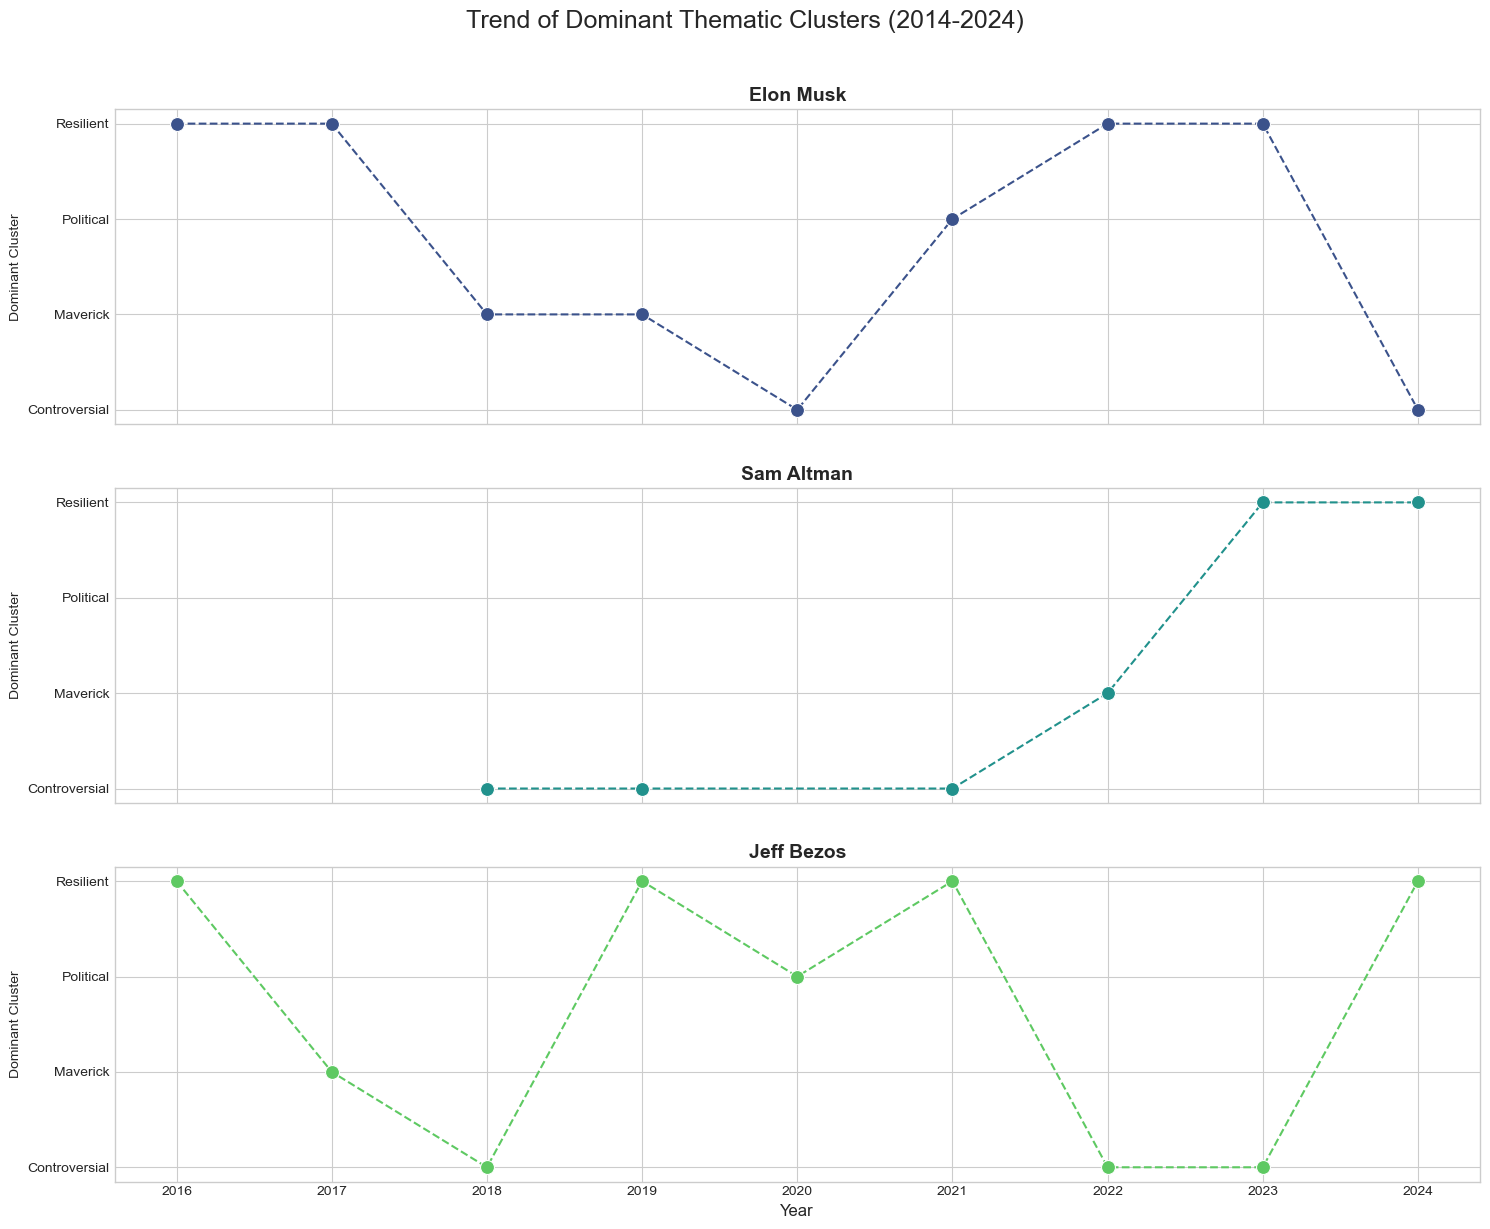

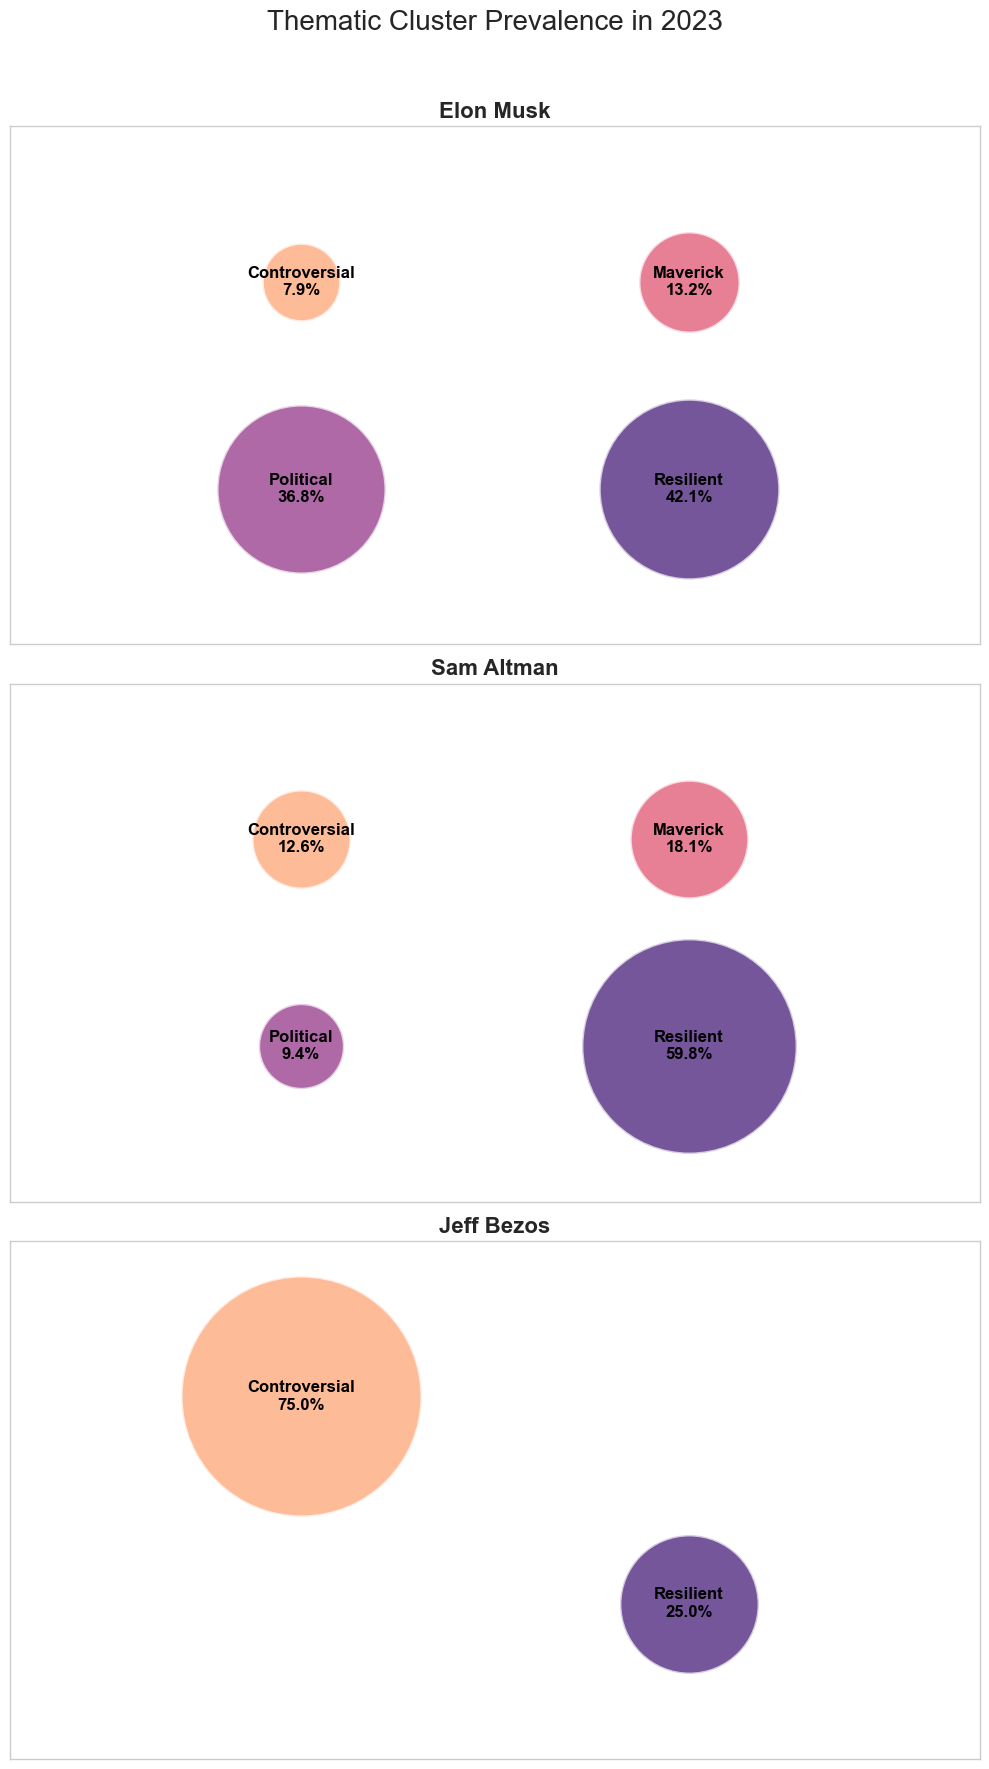

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =================================================================================
# --- 1. SETUP AND CONFIGURATION ---
# =================================================================================

INPUT_FILE = 'df_with_all_topics.csv'
PEOPLE_OF_INTEREST = ['Elon Musk', 'Sam Altman', 'Jeff Bezos']
START_YEAR = 2014
END_YEAR = 2024
SNAPSHOT_YEAR = 2023

# This dictionary is the single source of truth for cluster definitions.
TOPIC_TO_CLUSTER = {
    0: 'Controversial', 9: 'Controversial',
    1: 'Maverick',      3: 'Maverick',
    2: 'Political',     5: 'Political',     8: 'Political',
    4: 'Resilient',     7: 'Resilient',     6: 'Resilient'
}

# =================================================================================
# --- 2. CORE DATA PREPARATION (THE CONSISTENT LOGIC) ---
# =================================================================================

try:
    df = pd.read_csv(INPUT_FILE)
    print("Successfully loaded the complete topic dataset.")
except FileNotFoundError:
    print(f"Error: The file '{INPUT_FILE}' was not found.")
    exit()

# Filter for all people and years at once
analysis_df = df[
    (df['person_name'].isin(PEOPLE_OF_INTEREST)) &
    (df['Year'].between(START_YEAR, END_YEAR))
].copy()

# Map topics to clusters for the entire dataset
analysis_df['Cluster'] = analysis_df['Topic'].map(TOPIC_TO_CLUSTER)
analysis_df.dropna(subset=['Cluster'], inplace=True)

# --- This is the single, consistent logic engine ---
# a. Calculate prevalence for each individual topic
topic_counts = analysis_df.groupby(['person_name', 'Year', 'Topic']).size().reset_index(name='count')
total_counts = analysis_df.groupby(['person_name', 'Year']).size().reset_index(name='total_count')
prevalence_df = pd.merge(topic_counts, total_counts, on=['person_name', 'Year'])
prevalence_df['prevalence'] = prevalence_df['count'] / prevalence_df['total_count']
prevalence_df['Cluster'] = prevalence_df['Topic'].map(TOPIC_TO_CLUSTER)

# b. Calculate TOTAL cluster prevalence by SUMMING
total_cluster_prevalence_df = prevalence_df.groupby(['person_name', 'Year', 'Cluster'])['prevalence'].sum().reset_index()
print("\nCore analysis complete. Total prevalence calculated for all clusters, people, and years.")


# =================================================================================
# --- PLOT 1: Longitudinal Analysis (2014-2024) ---
# =================================================================================
print("\n--- Generating Longitudinal Trend Graph ---")
# Find the winning cluster for each person-year from our consistent data
idx = total_cluster_prevalence_df.groupby(['person_name', 'Year'])['prevalence'].idxmax()
dominant_cluster_df = total_cluster_prevalence_df.loc[idx].reset_index(drop=True)

# --- FIX: Explicitly convert cluster names to numbers for robust plotting ---
cluster_order = sorted(dominant_cluster_df['Cluster'].unique())
cluster_to_id = {cluster: i for i, cluster in enumerate(cluster_order)}
dominant_cluster_df['Cluster_ID'] = dominant_cluster_df['Cluster'].map(cluster_to_id)

fig1, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), sharex=True)
palette = sns.color_palette("viridis", n_colors=len(PEOPLE_OF_INTEREST))

for i, (ax, person) in enumerate(zip(axes1, PEOPLE_OF_INTEREST)):
    person_df = dominant_cluster_df[dominant_cluster_df['person_name'] == person]
    ax.set_title(person, fontsize=14, fontweight='bold')
    
    if not person_df.empty:
        # Plot the numeric 'Cluster_ID' on the y-axis
        sns.lineplot(data=person_df, x='Year', y='Cluster_ID', marker='o', markersize=10, linestyle='--', color=palette[i], ax=ax)
    
    # Label the y-axis ticks with the actual cluster names
    ax.set_ylabel('Dominant Cluster'); ax.set_xlabel('')
    ax.set_yticks(range(len(cluster_order)))
    ax.set_yticklabels(cluster_order)
    
axes1[-1].set_xlabel('Year', fontsize=12)
fig1.suptitle('Trend of Dominant Thematic Clusters (2014-2024)', fontsize=18, y=1.02)
plt.tight_layout(h_pad=3.0)
plt.savefig('consistent_longitudinal_trends.png', dpi=300)
print("✅ Longitudinal plot saved.")


# =================================================================================
# --- PLOT 2: Snapshot Bubble Chart (2023) ---
# =================================================================================
print("\n--- Generating 2023 Snapshot Bubble Chart ---")
snapshot_data = total_cluster_prevalence_df[total_cluster_prevalence_df['Year'] == SNAPSHOT_YEAR]

if not snapshot_data.empty:
    fig2, axes2 = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))
    bubble_palette = sns.color_palette("magma_r", n_colors=len(snapshot_data['Cluster'].unique()))
    cluster_to_color = dict(zip(sorted(snapshot_data['Cluster'].unique()), bubble_palette))
    positions = {'Controversial': (0.3, 0.7), 'Maverick': (0.7, 0.7), 'Political': (0.3, 0.3), 'Resilient': (0.7, 0.3)}
    bubble_size_scaler = 40000

    for i, (ax, person) in enumerate(zip(axes2, PEOPLE_OF_INTEREST)):
        person_df = snapshot_data[snapshot_data['person_name'] == person]
        ax.set_title(person, fontsize=16, fontweight='bold'); ax.grid(True, linestyle='--', linewidth=0.5)
        if not person_df.empty:
            for _, row in person_df.iterrows():
                cluster_name, prevalence = row['Cluster'], row['prevalence']
                x, y = positions.get(cluster_name, (0.5, 0.5))
                ax.scatter(x, y, s=prevalence * bubble_size_scaler, color=cluster_to_color.get(cluster_name), alpha=0.7, edgecolors='w', linewidth=2)
                ax.text(x, y, f"{cluster_name}\n{prevalence:.1%}", ha='center', va='center', color='black', fontweight='bold', fontsize=12)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_xticks([]); ax.set_yticks([])
    fig2.suptitle(f'Thematic Cluster Prevalence in {SNAPSHOT_YEAR}', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig('consistent_bubble_snapshot_2023.png', dpi=300)
    print("✅ 2023 snapshot bubble chart saved.")

# Display both generated figures
plt.show()